In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import preprocess, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, SpaceSampler
from hython.metrics import mse_metric

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset


from hython.utils import missing_location_idx, reconstruct_from_missing

from hython.models.lstm import CustomLSTM


# viz
import matplotlib.pyplot as plt
#import hvplot.xarray 
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

/home/iacopo/.local/build/mambaforge/envs/dl-pytorch/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [170]:
wd = Path("../data/datademo")
fp_dynamic_forcings = wd / "forcings.nc"
fp_wflow_static_params = wd / "staticmaps.nc"
fp_target = wd / "output.nc"


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc" , "actevap" ]

timeslice = slice("2016-01-01","2020-12-31")

### HYPERPARAMETERS

# training 

spatial_batch_size = 128
temporal_sampling_size = 150
seq_length = 260

# model 

hidden_size = 8

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [171]:
forcings = xr.open_dataset( fp_dynamic_forcings).rename({"latitude":"lat", "longitude":"lon"})
params = xr.open_dataset(fp_wflow_static_params ).rename({"latitude":"lat", "longitude":"lon"})
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))
targets

<xarray.Dataset> Size: 38MB
Dimensions:  (lon: 33, lat: 44, time: 2191)
Coordinates:
  * lon      (lon) float64 264B 11.2 11.21 11.22 11.23 ... 11.48 11.49 11.5
  * lat      (lat) float64 352B 46.6 46.59 46.58 46.57 ... 46.22 46.21 46.2
  * time     (time) datetime64[ns] 18kB 2015-01-02 2015-01-03 ... 2020-12-31
Data variables:
    actevap  (time, lat, lon) float32 13MB ...
    q_river  (time, lat, lon) float32 13MB ...
    vwc      (time, lat, lon) float32 13MB ...

In [172]:
if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

# Time

In [116]:
Xd, Xs, Y, *_ = preprocess(
                   forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [37]:
#  train valid split by time
Xd_train = Xd[:,:1500,:]
Xd_val = Xd[:,1500:,:]
Y_train = Y[:,:1500,:]
Y_val = Y[:,1500:,:]

Xd_train.shape, Xd_val.shape, Y_train.shape, Y_val.shape

((1452, 1500, 3), (1452, 327, 3), (1452, 1500, 2), (1452, 327, 2))

In [38]:
# normalization
Xd_train, d_m, d_std = apply_normalization(Xd_train, type = "spacetime", how ='standard')

Xd_val = apply_normalization(Xd_val, type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)

Xs, s_m, s_std = apply_normalization(Xs, type = "space", how ='standard')

Y_train, m1, m2 = apply_normalization(Y_train, type = "spacetime", how ='standard')

Y_val = apply_normalization(Y_val, type = "spacetime", how ='standard', m1 = m1, m2 = m2)

In [39]:
Xd_train.shape, Xd_val.shape, Y_train.shape, Y_val.shape, Xs.shape

((1452, 1500, 3), (1452, 327, 3), (1452, 1500, 2), (1452, 327, 2), (1452, 8))

In [40]:
Xs = torch.Tensor(Xs)

Xd_train = torch.Tensor(Xd_train)
Xd_val = torch.Tensor(Xd_val)

Y_train = torch.Tensor(Y_train)
Y_val = torch.Tensor(Y_val)

In [41]:
train_dataset = LSTMDataset(Xd_train, Y_train, Xs)
valid_dataset = LSTMDataset(Xd_val, Y_val, Xs)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset , batch_size=64, shuffle=False)

In [43]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=16, bias=True)
  (lstm): LSTM(16, 16, batch_first=True)
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [44]:
# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 10

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names":target_names

}

In [45]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/9, current lr=0.01


RuntimeError: Expected sequence length to be larger than 0 in RNN

# Space

In [209]:
X = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

In [210]:
# remove missing before sampling and reshaping? 
# if removing after then the sampling indices may hit a indexing error as they were computed before remove missing

In [211]:
# initialize samplers
spatial_train_sampler = RegularIntervalSampler(
                                 intervals = (3,3),
                                 origin = (0,0)
                    )
spatial_val_sampler = RegularIntervalSampler(
                                 intervals = (3,3),
                                 origin = (2,2)
                    ) 

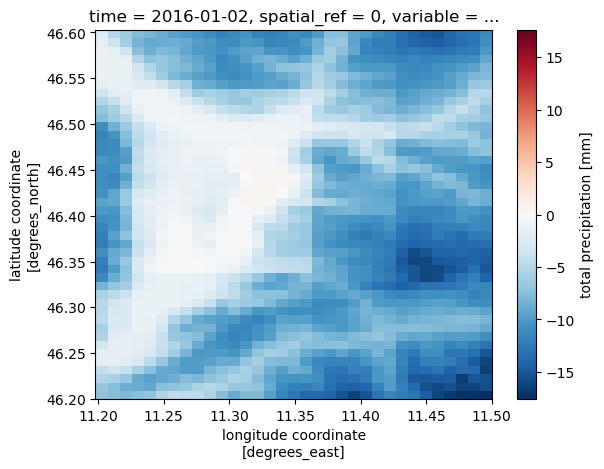

In [212]:
X.isel(time=1, variable=2).plot()

In [213]:
# return  indices of sampled cells
_, X_train_meta = spatial_train_sampler.sampling(X.values)
_, X_val_meta = spatial_val_sampler.sampling(X.values)

In [214]:
X_train_meta.idx_sampled_1d, X_val_meta.idx_sampled_1d

(array([   0,    3,    6,    9,   12,   15,   18,   21,   24,   27,   30,
          99,  102,  105,  108,  111,  114,  117,  120,  123,  126,  129,
         198,  201,  204,  207,  210,  213,  216,  219,  222,  225,  228,
         297,  300,  303,  306,  309,  312,  315,  318,  321,  324,  327,
         396,  399,  402,  405,  408,  411,  414,  417,  420,  423,  426,
         495,  498,  501,  504,  507,  510,  513,  516,  519,  522,  525,
         594,  597,  600,  603,  606,  609,  612,  615,  618,  621,  624,
         693,  696,  699,  702,  705,  708,  711,  714,  717,  720,  723,
         792,  795,  798,  801,  804,  807,  810,  813,  816,  819,  822,
         891,  894,  897,  900,  903,  906,  909,  912,  915,  918,  921,
         990,  993,  996,  999, 1002, 1005, 1008, 1011, 1014, 1017, 1020,
        1089, 1092, 1095, 1098, 1101, 1104, 1107, 1110, 1113, 1116, 1119,
        1188, 1191, 1194, 1197, 1200, 1203, 1206, 1209, 1212, 1215, 1218,
        1287, 1290, 1293, 1296, 1299, 

In [215]:
# reshape for training

Xd, Xs, Y, *_ = preprocess(
                forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )


dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [216]:
# Normalizing

Xd[X_train_meta.idx_sampled_1d], d_m, d_std = apply_normalization(Xd[X_train_meta.idx_sampled_1d], type = "spacetime", how ='standard')
Xs[X_train_meta.idx_sampled_1d], s_m, s_std = apply_normalization(Xs[X_train_meta.idx_sampled_1d], type = "space", how ='standard')

#Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

Xd[X_val_meta.idx_sampled_1d] = apply_normalization(Xd[X_val_meta.idx_sampled_1d], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
Xs[X_val_meta.idx_sampled_1d] = apply_normalization(Xs[X_val_meta.idx_sampled_1d], type = "space", how ='standard', m1 = s_m, m2 = s_std)

In [217]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

In [218]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [219]:
train_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_train_meta.idx_sampled_1d.tolist())
valid_sampler = SpaceSampler(dataset, num_samples=5, sampling_indices = X_val_meta.idx_sampled_1d.tolist())

In [220]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

In [221]:
model = CustomLSTM(model_params)
model = model.to(device)
model


CustomLSTM(
  (fc0): Linear(in_features=11, out_features=8, bias=True)
  (lstm): LSTM(8, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [222]:
# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 100

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_type": "dynamic" # static
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names":target_names

}

In [223]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/99, current lr=0.01
Copied best model weights!
train loss: 0.002964341314509511, train metric: {'vwc': 0.0039998465, 'actevap': 0.048172556}
val loss: 0.008415939286351204, val metric: {'vwc': 0.025281413, 'actevap': 0.1334192}
----------
Epoch 1/99, current lr=0.01
train loss: 0.0011567469919100404, train metric: {'vwc': 0.0022563166, 'actevap': 0.018102426}
val loss: 0.008461011573672295, val metric: {'vwc': 0.017823128, 'actevap': 0.14172731}
----------
Epoch 2/99, current lr=0.01
train loss: 0.0010242959251627326, train metric: {'vwc': 0.0017745469, 'actevap': 0.016253062}
val loss: 0.008832266554236412, val metric: {'vwc': 0.005035692, 'actevap': 0.16151565}
----------
Epoch 3/99, current lr=0.01
Copied best model weights!
train loss: 0.0009956056019291282, train metric: {'vwc': 0.0015715692, 'actevap': 0.015951095}
val loss: 0.00790724903345108, val metric: {'vwc': 0.0064379713, 'actevap': 0.14267011}
----------
Epoch 4/99, current lr=0.01
train loss: 0.001008004881441593

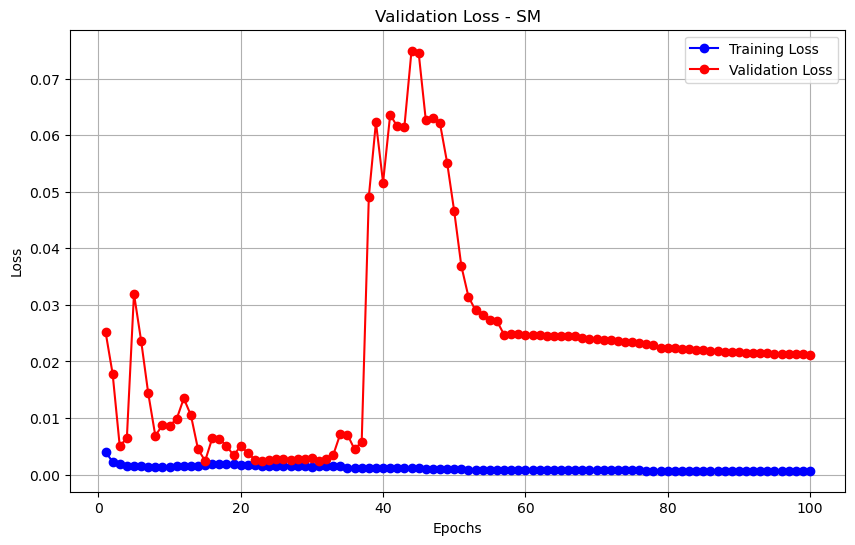

In [224]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_vwc"]
val_loss = sm_metric_history["val_vwc"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

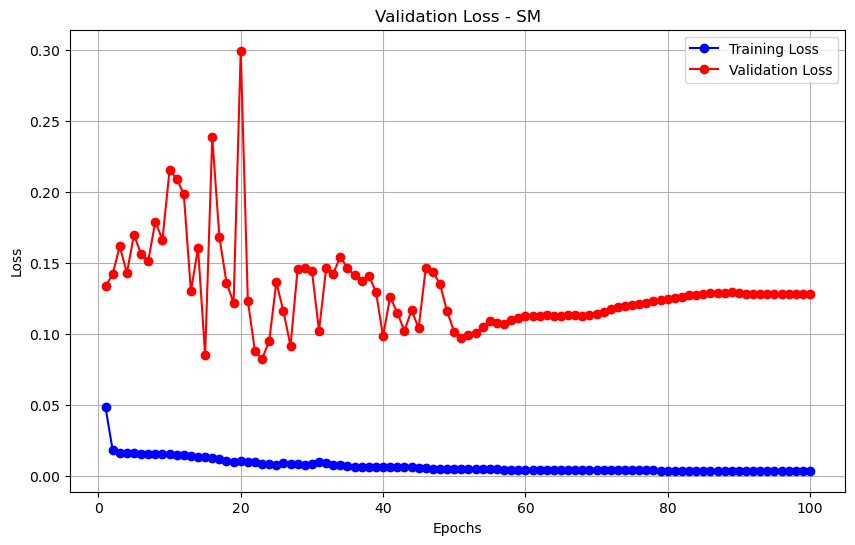

In [225]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history["train_actevap"]
val_loss = sm_metric_history["val_actevap"]

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### Inference

In [226]:
Xd_all, Xs_all, Y_all, *_  = preprocess(forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 2)  => (GRIDCELL, TIME, TARGET)


In [227]:
# inference 
yhat = predict(Xd_all, Xs_all, model, spatial_batch_size, device)
yhat.shape

(1452, 1827, 2)

In [228]:
lat, lon, time = X.shape[:-1]
lat*lon ,time

(1452, 1827)

In [229]:
y_target, y_pred = prepare_for_plotting(y_target=Y_all[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets.coords)
y_target.shape

(44, 33, 1827)

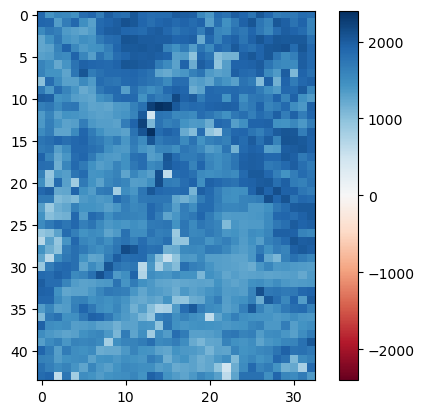

In [230]:
map_bias(y_target, y_pred)

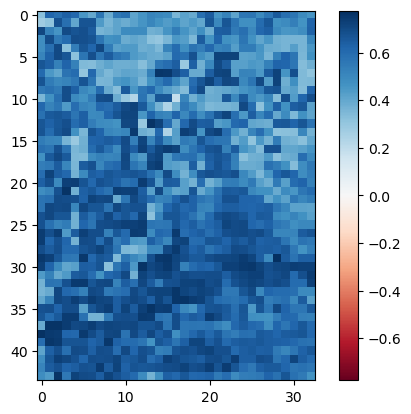

In [231]:
map_pearson(y_target, y_pred)

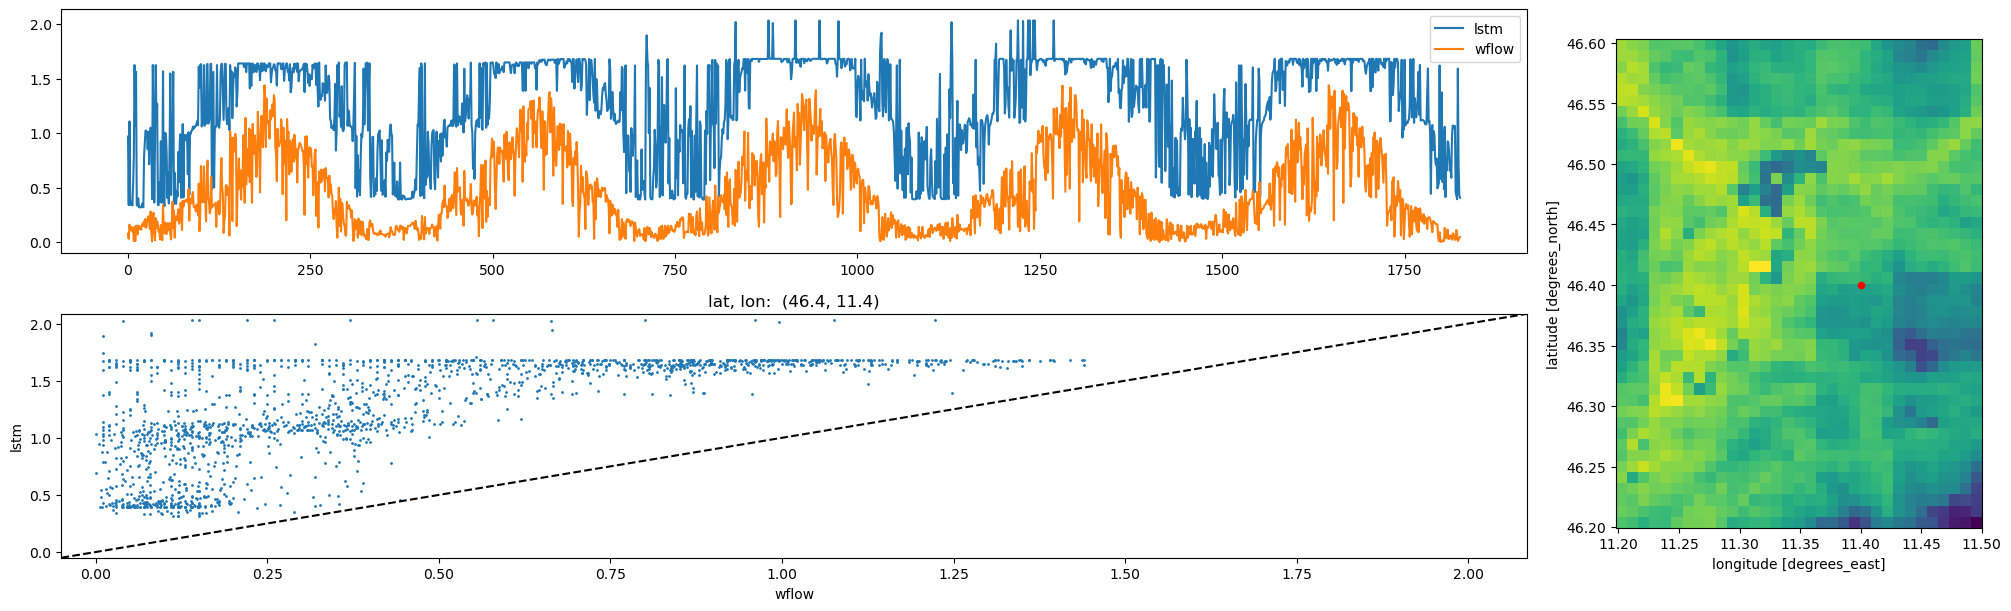

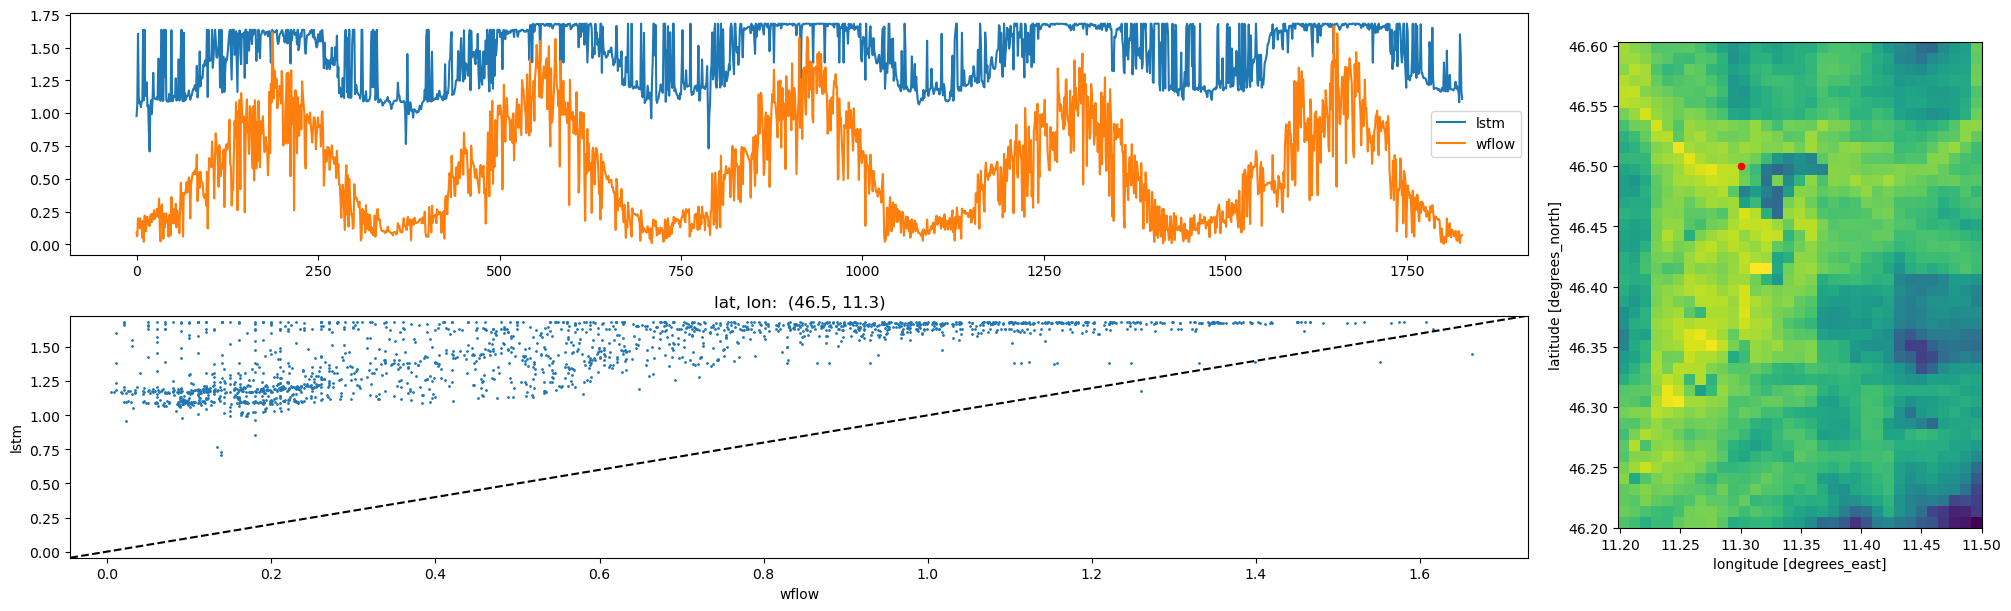

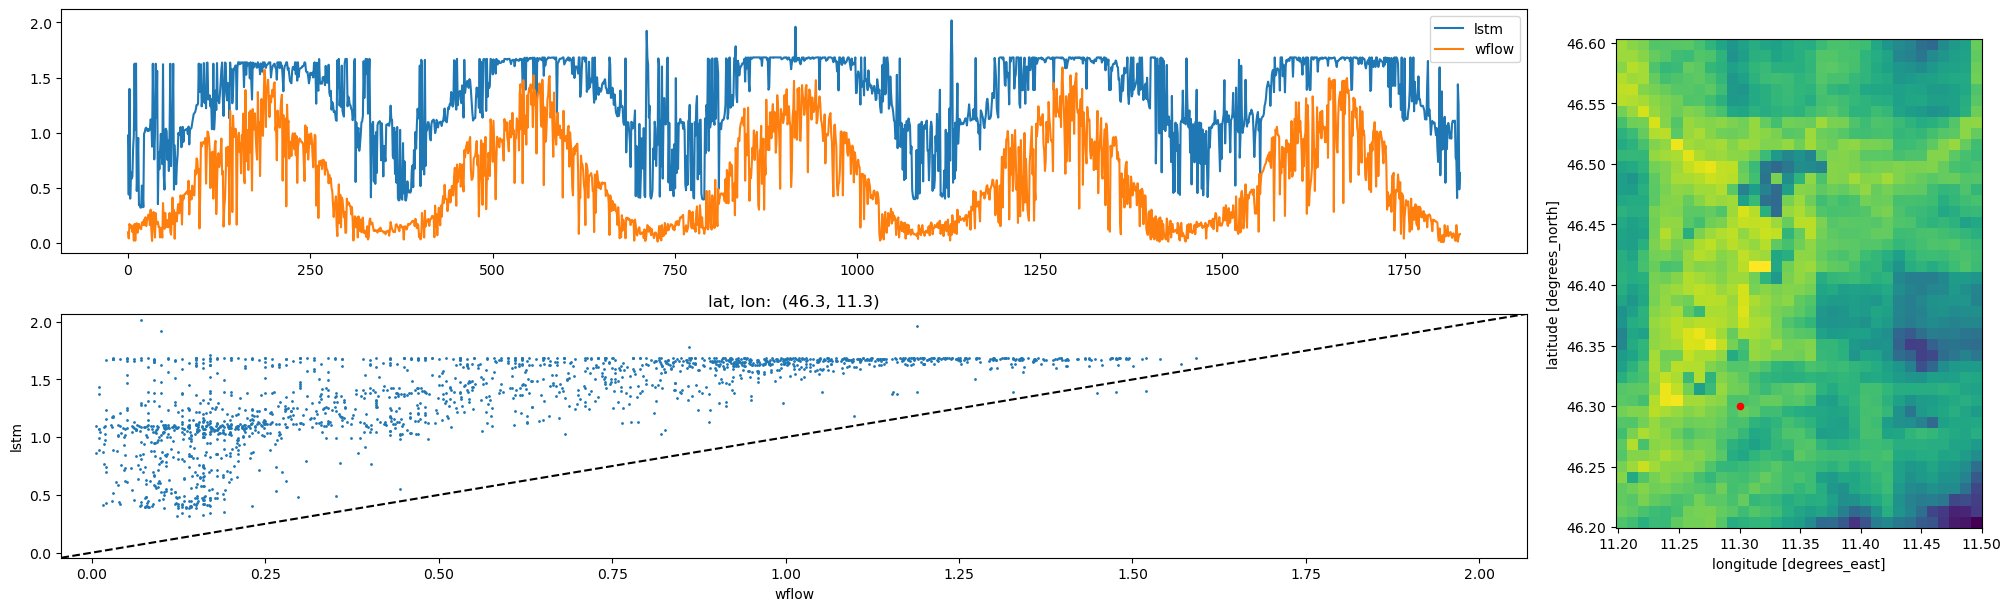

In [234]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5, 46.3], lon = [11.4, 11.3, 11.3])

In [ ]:
# SpaceTime

In [71]:
from torch.utils.data import Dataset,DataLoader

In [108]:
class B(Dataset):

    def __init__(self,X):
        self.X = X

    def __getitem__(self, i, j):
        return self.X[i, j]
        
    def __len__(self):
        return self.X.shape[0]
    

In [109]:
d = B(np.arange(100).reshape(10,10))

In [107]:
dl = DataLoader(d, batch_size=7)

In [ ]:
for i in dl:
    print(i)

In [114]:
# https://discuss.pytorch.org/t/custom-dataset-with-getitem-method-that-requires-two-indices-as-input/62083/2